# Auto Image Coloring CNN

## Prabhat R

*This project is a very basic implementation of an automatic image coloring ConvNet regressor, inspired by the SIGGRAPH 2016 paper on deep colorization. *
The results can be seen at the end of this page. As you can/will see the very simple Network does a decent job of predicting the chrominance of the image, and looks pretty similar to output of a sepia filter. 

In [41]:
torch.setdefaulttensortype('torch.FloatTensor')
torch=require('torch')

## Load Image Dataset  

In [42]:
lfs=require 'lfs'
lfs.chdir('/Users/prabhat/Desktop')
load_images = require 'load_images'
images = load_images.load('face_images', 750)

In [43]:
require('image');

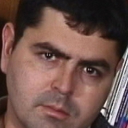

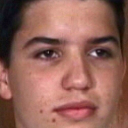

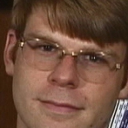

In [44]:
for i=1,3 do
    itorch.image(images[i])
end

In [79]:
-- cloning the train dataset 
images_copy=images:clone()

-- random shuffed vector for image index 
shuff=torch.randperm(images:size(1))

-- lets randomly shuffle the train data 
for i=1,images:size(1) do 
	images[i]=images_copy[shuff[i]]
end 


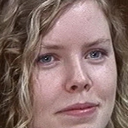

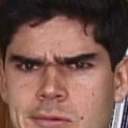

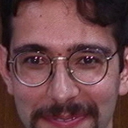

In [80]:
for i=1,3 do
    itorch.image(images[i])
end

## Data Augmentation 

In [81]:
-- create an empty tensor to hold the augmented data (10x the original data)

augData=torch.Tensor(7500,3,128,128)

-- lets insert the original images 
for i=1,images:size(1) do
	augData[i]=images[i]
end

horizontal flips (makes data 2x)

In [82]:
for i=(images:size(1)+1),(images:size(1)*2) do 
	augData[i]=image.hflip(images[i-images:size(1)])
end 

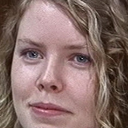

In [83]:
itorch.image(augData[751])
-- example of horizontal flip data augmentation 

random crops on the original and horizontal flips(makes the data 4x)

In [84]:
for i=((images:size(1)*2)+1),((images:size(1)*4)) do 
	a=image.crop(augData[i-(images:size(1)*2)],'c', 75,75)
	augData[i]=image.scale(augData[i],a)
end 


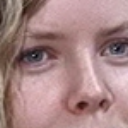

In [85]:
itorch.image(augData[1501])
-- example of second transformation

scaling RGB and vertical flip on the original+augmented data so far(makes the data 8x)

In [86]:
for i=((images:size(1)*4)+1),((images:size(1)*8)) do
	augData[i]=((augData[i-(images:size(1)*4)])*(0.3))
    augData[i]= image.vflip(augData[i])
end 

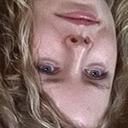

In [87]:
itorch.image(augData[3001])
-- example of third transformation

crop again at the bottom left images to increase data to make it 2x

In [88]:
for i=((images:size(1)*8)+1),((images:size(1)*10)) do 
	a=image.crop(augData[i-(images:size(1)*8)],'bl', 85,85)
	augData[i]=image.scale(augData[i],a)
end 



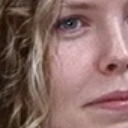

In [89]:
itorch.image(augData[6001])
-- example of fourth transformation

In [90]:
print(augData:size(1))
-- increased data by 10x

7500	


Shuffling the data just coz

In [91]:
-- cloning the train dataset 
augData_copy=augData:clone()

-- random shuffed vector for image index 
shuff=torch.randperm(augData:size(1))

-- lets randomly shuffle the train data 
for i=1,augData:size(1) do 
	augData[i]=augData_copy[shuff[i]]
end 

In [92]:
augData_copy=nil;
images_copy=nil;

## Conversion to L* a* b*

In [93]:
augDataLAB=augData:clone()
for i=1,augData:size(1) do
    augDataLAB[i]=image.rgb2lab(augData[i])
end

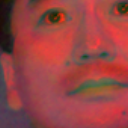

In [107]:
itorch.image(augDataLAB[623])
-- the LAB image

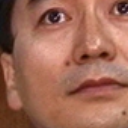

In [108]:
itorch.image(augData[623])
-- the original image 

## Simple Regressor for mean a* and  mean b* prediction using L*

### Lets build the Data

In [109]:
#augDataLAB

 7500
    3
  128
  128
[torch.LongStorage of size 4]



In [110]:
y = torch.Tensor(7500,2,1)


In [111]:
for i=1,7500 do 
    y[i][1][1]=torch.mean(augDataLAB[i][2])/128
    y[i][2][1]=torch.mean(augDataLAB[i][3])/128
    
end

In [112]:
x=torch.Tensor(7500,1,128,128)

In [113]:
for i=1,7500 do 
    x[i][1]=augDataLAB[i][1]/100
end 

In [114]:
--print(x[1]) 
-- just checking 

### Lets build the network 

In [115]:
require 'nn';
require 'pretty-nn';

In [118]:
model=nil;

In [119]:
model=nn.Sequential()
-- FIRST LAYER
model:add(nn.SpatialConvolution(1,3,2,2,2,2))
model:add(nn.ReLU())

-- SECOND LAYER
model:add(nn.SpatialConvolution(3,3,2,2,2,2))
model:add(nn.ReLU())
-- THIRD LAYER 
model:add(nn.SpatialConvolution(3,3,2,2,2,2))
model:add(nn.ReLU())
-- FOURTH
model:add(nn.SpatialConvolution(3,3,2,2,2,2))
model:add(nn.ReLU())
-- FIFTH 
model:add(nn.SpatialConvolution(3,3,2,2,2,2))
model:add(nn.ReLU())
-- SIXTH 
model:add(nn.SpatialConvolution(3,3,2,2,2,2))
model:add(nn.ReLU())
-- SEVENTH
model:add(nn.SpatialConvolution(3,2,2,2,2,2))
model:add(nn.Tanh())
--

In [120]:
loss=nn.MSECriterion()

In [121]:
for i=1,7500 do
    -- make prediction
    pred=model:forward(x[i])
    -- calculate the loss
    E=loss:forward(pred,y[i])
    -- gradient of error with output
    gradCriterion=loss:backward(pred,y[i])
    -- reset the gradient of parameters to zero 
    model:zeroGradParameters()
    -- update the gradiesnts for all the layers
    model:backward(x[i],gradCriterion)
    -- learning rate 
    lam=0.01
    -- update the parameters 
    model:updateParameters(lam)
    er=0
    if i%1000==0 or i==100 or i==50 then
        for j=1,7500 do
            pred1=model:forward(x[j])
            Err=loss:forward(pred1,y[j])
            er=er+Err
        end
    print('The training error',er,'and iteration number',i)    
    
    end
end

The training error	89.345098229125	and iteration number	50	


The training error	33.274615887596	and iteration number	100	


The training error	12.700060770886	and iteration number	1000	


The training error	12.797817561658	and iteration number	2000	


The training error	12.979055717661	and iteration number	3000	


The training error	12.738222755275	and iteration number	4000	


The training error	12.934330572471	and iteration number	5000	


The training error	12.697767681643	and iteration number	6000	


The training error	12.745981831306	and iteration number	7000	


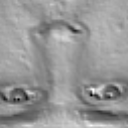

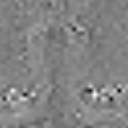

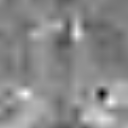

In [203]:
-- vizuvalize the first three convolution layers of the regressor network 
model:forward(x[6])
itorch.image(image.scale((model:get(1).output[2]),128,128))
itorch.image(image.scale((model:get(3).output[1]),128,128))
itorch.image(image.scale((model:get(5).output)[1],128,128))
-- the first convolution layer is annoyingly similar to the input image? I wonder why

In [130]:
-- lets vizuvalize the results by viewing the images with true and predictied mean chrominance
image1 = torch.Tensor(1,3,128,128)
-- using the L* of the image 
image1[1][1]= x[1]*100

In [131]:
-- getting the actual mean chrominance of the image 
y[1]

 0.1148
 0.1322
[torch.FloatTensor of size 2x1]



In [137]:
-- setting the chanel a* and b* with the mean chrominance 
image1[1][2]=torch.Tensor(128,128):fill(0.1148*128)
image1[1][3]=torch.Tensor(128,128):fill(0.1322*128)


In [133]:
-- lets predict the chrominance values 
pred=model:forward(x[1])

In [134]:
pred

(1,.,.) = 
 0.01 *
   7.5309

(2,.,.) = 
 0.01 *
   7.0065
[torch.FloatTensor of size 2x1x1]



In [135]:
-- lets use these mean chrominance values and set the chanel a* and b*
image2 = torch.Tensor(1,3,128,128)
-- using the L* of the image 
image2[1][1]= x[1]*100
image2[1][2]=torch.Tensor(128,128):fill(0.075309*128)
image2[1][3]=torch.Tensor(128,128):fill(0.070065*128)

the image with actual mean chrominance in LAB color space:	


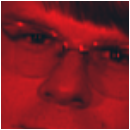

the image with actual mean chrominance in rgb space:	


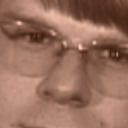

In [145]:
-- this image looks like:  
print('the image with actual mean chrominance in LAB color space:')
itorch.image(image1)
print('the image with actual mean chrominance in rgb space:')
itorch.image(image.lab2rgb(image1[1]))

the image with predicted mean chrominance in Lab color space:	


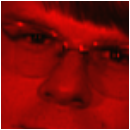

the image with predicted mean chrominance in rgb space:	


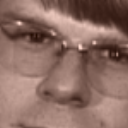

In [144]:
-- the predicted image by the regressor
print('the image with predicted mean chrominance in Lab color space:')
itorch.image(image2)
-- rgb image with predicted means for a* b*
print('the image with predicted mean chrominance in rgb space:')
itorch.image(image.lab2rgb(image2[1]))

the original image in LAB and rgb space:	


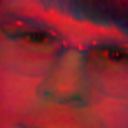

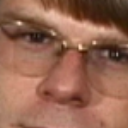

In [146]:
--The original image 
print('the original image in LAB and rgb space:')
itorch.image(augDataLAB[1])
itorch.image(image.lab2rgb(augDataLAB[1]))

## Coloring Net

### DataSet

In [147]:
-- just segregating the output channels for the colorNet
y = torch.Tensor(7500,2,128,128)
for i=1,7500 do 
    y[i][1]=(augDataLAB[i][2])/128
    y[i][2]=(augDataLAB[i][3])/128
end

In [165]:
colorNet=nil;

## Lets build the network

In [166]:
colorNet=nn.Sequential()
-- FIRST LAYER
colorNet:add(nn.SpatialConvolution(1,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- SECOND LAYER
colorNet:add(nn.SpatialConvolution(3,6,2,2,2,2))
colorNet:add(nn.ReLU())
-- THIRD LAYER 
colorNet:add(nn.SpatialConvolution(6,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- FOURTH
colorNet:add(nn.SpatialConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- FIFTH 
colorNet:add(nn.SpatialConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- SIXTH 
colorNet:add(nn.SpatialConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- Seventh
colorNet:add(nn.SpatialFullConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
-- eighth 
colorNet:add(nn.SpatialFullConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
--ninth
colorNet:add(nn.SpatialFullConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
--tenth 
colorNet:add(nn.SpatialFullConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
--eleventh
colorNet:add(nn.SpatialFullConvolution(3,3,2,2,2,2))
colorNet:add(nn.ReLU())
--twelveth 
colorNet:add(nn.SpatialFullConvolution(3,2,2,2,2,2))
colorNet:add(nn.Tanh())

In [167]:
colorloss=nn.MSECriterion()

In [168]:
for i=1,7500 do
    -- make prediction
    pred=colorNet:forward(x[i])
    -- calculate the loss
    E=colorloss:forward(pred,y[i])
    -- gradient of error with output
    gradCriterion=colorloss:backward(pred,y[i])
    -- reset the gradient of parameters to zero 
    colorNet:zeroGradParameters()
    -- update the gradiesnts for all the layers
    colorNet:backward(x[i],gradCriterion)
    -- learning rate 
    lam=0.01
    -- update the parameters 
    colorNet:updateParameters(lam)
    
    if i%1000==0 then 
        er=0
        for j=1,7500 do
            pred1=colorNet:forward(x[j])
            Err=colorloss:forward(pred1,y[j])
            er=er+Err
        end
        print('training error:',er,'iteration:',i)      
    end   
end

training error:	23.598482757108	iteration:	1000	


training error:	21.336013315013	iteration:	2000	


training error:	20.444480371138	iteration:	3000	


training error:	19.863638282404	iteration:	4000	


training error:	19.719436895975	iteration:	5000	


training error:	19.488616986026	iteration:	6000	


training error:	19.42428770056	iteration:	7000	


In [169]:
pred=colorNet:forward(x[1])

In [171]:
imagez=torch.Tensor(1,3,128,128)
imagez[1][1]=x[1]*100
imagez[1][2]=pred[1]*128
imagez[1][3]=pred[2]*128

In [172]:
oimagez=torch.Tensor(1,3,128,128)
oimagez[1][1]=x[1]*100
oimagez[1][2]=y[1][1]*128
oimagez[1][3]=y[1][2]*128


the networks coloring on a training set image in rgb:	


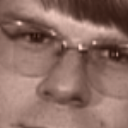

the original image in rgb:	


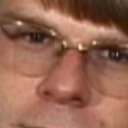

In [175]:
print('the networks coloring on a training set image in rgb:')
itorch.image(image.lab2rgb(imagez[1]))

print('the original image in rgb:')
itorch.image(image.lab2rgb(oimagez[1]))

## Batch Normalization

### DataSet

In [176]:
batch_x=torch.Tensor(750,1,10,128,128)
batch_y=torch.Tensor(750,2,10,128,128)
-- lets create 4D tensors, with each first dimension comprising of a batch with 10 images 
-- so batch_x[1] will contain the L* of the first ten images 
-- batch_y[1] will contain the a* and b* of the first ten images 

In [177]:
for i=1,745 do
    for k=1,10 do
        batch_x[i][1][k]=augDataLAB[(i-1)*10+k][1]/100
        batch_y[i][1][k]=augDataLAB[(i-1)*10+k][2]/128
        batch_y[i][2][k]=augDataLAB[(i-1)*10+k][3]/128
    end
end

### Building the network 

In [184]:
cNet=nil;

In [185]:
cNet=nn.Sequential()
-- FIRST LAYER
cNet:add(nn.SpatialConvolution(10,30,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(30))
cNet:add(nn.Tanh())
-- SECOND LAYER
cNet:add(nn.SpatialConvolution(30,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- THIRD LAYER 
cNet:add(nn.SpatialConvolution(60,100,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(100))
cNet:add(nn.Tanh())
-- FOURTH
cNet:add(nn.SpatialConvolution(100,80,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(80))
cNet:add(nn.Tanh())
-- FIFTH 
cNet:add(nn.SpatialConvolution(80,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- SIXTH 
cNet:add(nn.SpatialConvolution(60,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- Seventh
cNet:add(nn.SpatialFullConvolution(60,50,2,2,2,2))
cNet:add(nn.Tanh())
-- eighth 
cNet:add(nn.SpatialFullConvolution(50,40,2,2,2,2))
cNet:add(nn.Tanh())
--ninth
cNet:add(nn.SpatialFullConvolution(40,40,2,2,2,2))
cNet:add(nn.Tanh())
--tenth 
cNet:add(nn.SpatialFullConvolution(40,30,2,2,2,2))
cNet:add(nn.Tanh())
--eleventh
cNet:add(nn.SpatialFullConvolution(30,30,2,2,2,2))
cNet:add(nn.Tanh())
--twelveth 
cNet:add(nn.SpatialFullConvolution(30,20,2,2,2,2))
cNet:add(nn.Tanh())

In [186]:
closs=nn.MSECriterion()
-- closs.sizeAverage = false

In [187]:
for i=1,750 do
    -- make prediction
    pred=cNet:forward(batch_x[i])
    -- calculate the loss
    E=closs:forward(pred,batch_y[i])
    -- gradient of error with output
    gradCriterion=closs:backward(pred,batch_y[i])
    -- reset the gradient of parameters to zero 
    cNet:zeroGradParameters()
    -- update the gradiesnts for all the layers
    cNet:backward(batch_x[i],gradCriterion)
    -- learning rate 
    lam=0.01
    -- update the parameters 
    cNet:updateParameters(lam)
    
    if i%100==0 or i==10 then 
        er=0
        for j=1,750 do
            pred1=cNet:forward(batch_x[j])
            Err=closs:forward(pred1,batch_y[j])
            er=er+Err
        end
        print('training error:',er,'batch number:',i)
    end
end

training error:	

5.999631569488	batch number:	10	


training error:	5.3368170683971	batch number:	100	


training error:	4.7193650474073	batch number:	200	


training error:	4.2281879774528	batch number:	300	


training error:	3.8326595780673	batch number:	400	


training error:	3.4962228783406	batch number:	500	


training error:	3.2336837840267	batch number:	600	


training error:	3.009653584566	batch number:	700	


* loss is decreasing so thats a sanity check that the network is working. 
* lets just look at how the model colors one of the images that  its been trained on 

In [189]:
--should have written a function to view the original image and the corresponding
-- input & output to and of the coloring network. but here it goes...
t=75
pred=cNet:forward(batch_x[t])
aaa=pred[1][1]*128
bbb=pred[1][2]*128
lll=batch_x[t][1][1]*100
resz=torch.Tensor(3,128,128)
resz[1]=lll
resz[2]=aaa
resz[3]=bbb
oresz=torch.Tensor(3,128,128)
oresz[1]=lll
aaa=batch_y[t][1][1]*128
bbb=batch_y[t][2][1]*128
oresz[2]=aaa
oresz[3]=bbb
gr=torch.Tensor(1,128,128)
gr[1]=lll

the input to the coloring network:	


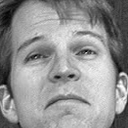

the coloring networks output in rgb:	


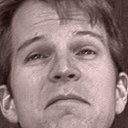

the original image in rgb:	


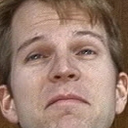

In [193]:
-- the input to the network 
print('the input to the coloring network:')
itorch.image(gr)
-- networks coloring 
print('the coloring networks output in rgb:')
itorch.image(image.lab2rgb(resz))
-- original colored image 
print('the original image in rgb:')
itorch.image(image.lab2rgb(oresz))

### What are initial layers learning??

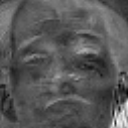

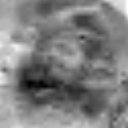

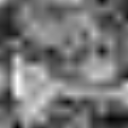

In [194]:
-- vizuvalize the first three convolution layers of the regressor network 
itorch.image(image.scale((cNet:get(1).output[1][1]),128,128))
itorch.image(image.scale((cNet:get(4).output[1][1]),128,128))
itorch.image(image.scale((cNet:get(7).output[1][1]),128,128))

seems like some edges information like the face shape eyes mouth and nose are being captured by the 
first conv layer, second and third are bit more complex, though a few face impressions can be seen 
in the second conv layer viz.

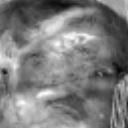

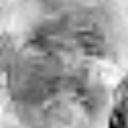

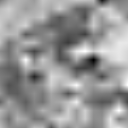

In [195]:
itorch.image(image.scale((cNet:get(1).output[1][2]),128,128))
itorch.image(image.scale((cNet:get(4).output[1][2]),128,128))
itorch.image(image.scale((cNet:get(7).output[1][2]),128,128))

# Training & Testing 

### Dataset: Training set and testing set 

In [204]:
lfs=require 'lfs'
lfs.chdir('/Users/prabhat/Desktop')
load_images = require 'load_images'
All_Img = load_images.load('face_images', 750)

In [205]:
-- cloning the train dataset 
ALL_copy=All_Img:clone()
-- random shuffed vector for image index 
shuff=torch.randperm(All_Img:size(1))
-- lets randomly shuffle the train data 
for i=1,All_Img:size(1) do 
	All_Img[i]=ALL_copy[shuff[i]]
end 
ALL_copy=nil;

In [206]:
TestImg=torch.Tensor(75,3,128,128)
for i=1,75 do 
    TestImg[i]=All_Img[i]
end

In [207]:
TrainImg=torch.Tensor(675,3,128,128)
for i=1,675 do 
    TrainImg[i]=All_Img[75+i]
end

In [208]:
All_Img=nil;

division is done, now we augment the training data to make it 10x larger

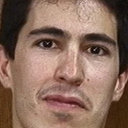

In [209]:
augTrain=torch.Tensor(6750,3,128,128)
-- copy the initial images into augTrain
for i=1,TrainImg:size(1) do
	augTrain[i]=TrainImg[i]
end
itorch.image(augTrain[1])

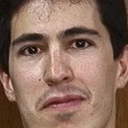

In [210]:
-- first horizontal flip
for i=(TrainImg:size(1)+1),(TrainImg:size(1)*2) do 
	augTrain[i]=image.hflip(TrainImg[i-TrainImg:size(1)])
end 
itorch.image(augTrain[676])

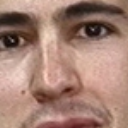

In [211]:
-- now random crop 
for i=((TrainImg:size(1)*2)+1),((TrainImg:size(1)*4)) do 
	a=image.crop(augTrain[i-(TrainImg:size(1)*2)],'c', 75,75)
	augTrain[i]=image.scale(augTrain[i],a)
end 
itorch.image(augTrain[2026])


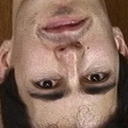

In [212]:
-- now rgb scaling and vertical flip
for i=((TrainImg:size(1)*4)+1),((TrainImg:size(1)*8)) do
	augTrain[i]=((augTrain[i-(TrainImg:size(1)*4)])*(0.3))
    augTrain[i]= image.vflip(augTrain[i])
end 
itorch.image(augTrain[2701])

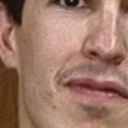

In [213]:
-- now crop bottom left of the first 675*2 images
for i=((TrainImg:size(1)*8)+1),((TrainImg:size(1)*10)) do 
	a=image.crop(augTrain[i-(TrainImg:size(1)*8)],'bl', 85,85)
	augTrain[i]=image.scale(augTrain[i],a)
end 
itorch.image(augTrain[5401])

In [214]:
-- cloning the train dataset 
augTrain_copy=augTrain:clone()
-- random shuffed vector for image index 
shuff=torch.randperm(augTrain:size(1))
-- lets randomly shuffle the train data 
for i=1,augTrain:size(1) do 
	augTrain[i]=augTrain_copy[shuff[i]]
end 

In [215]:
augTrain_copy=nil;

In [216]:
-- now convert the training data into L*a*b* color space 
augTrainLAB=augTrain:clone()
for i=1,augTrain:size(1) do
    augTrainLAB[i]=image.rgb2lab(augTrain[i])
end

a training image in LAB color space and rgb space	


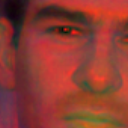

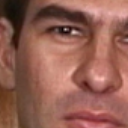

In [217]:
print('a training image in LAB color space and rgb space')
itorch.image(augTrainLAB[34])
itorch.image(augTrain[34])

In [218]:
-- converting testing images to Lab color space 
TestLAB=TestImg:clone()
for i=1,TestImg:size(1) do
    TestLAB[i]=image.rgb2lab(TestImg[i])
end

In [219]:
-- mini batches 
batch_x=torch.Tensor(675,1,10,128,128)
batch_y=torch.Tensor(675,2,10,128,128)
-- lets create 4D tensors, with each first dimension comprising of a batch with 10 images 
-- so batch_x[1] will contain the L* of the first ten images 
-- batch_y[1] will contain the a* and b* of the first ten images 
for i=1,675 do
    for k=1,10 do
        batch_x[i][1][k]=augDataLAB[(i-1)*10+k][1]/100
        batch_y[i][1][k]=augDataLAB[(i-1)*10+k][2]/128
        batch_y[i][2][k]=augDataLAB[(i-1)*10+k][3]/128
    end
end

In [220]:
-- Test mini batches 
Tbatch_x=torch.Tensor(70,1,10,128,128)
Tbatch_y=torch.Tensor(70,2,10,128,128)
-- lets create 4D tensors, with each first dimension comprising of a batch with 10 images 
-- so batch_x[1] will contain the L* of the first ten images 
-- batch_y[1] will contain the a* and b* of the first ten images 
for i=1,7 do
    for k=1,10 do
        Tbatch_x[i][1][k]=TestLAB[(i-1)*10+k][1]/100
        Tbatch_y[i][1][k]=TestLAB[(i-1)*10+k][2]/128
        Tbatch_y[i][2][k]=TestLAB[(i-1)*10+k][3]/128
    end
end

## Build the network

In [245]:
cNet=nil;

In [246]:
cNet=nn.Sequential()
-- FIRST LAYER
cNet:add(nn.SpatialConvolution(10,30,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(30))
cNet:add(nn.Tanh())
-- SECOND LAYER
cNet:add(nn.SpatialConvolution(30,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- THIRD LAYER 
cNet:add(nn.SpatialConvolution(60,100,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(100))
cNet:add(nn.Tanh())
-- FOURTH
cNet:add(nn.SpatialConvolution(100,80,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(80))
cNet:add(nn.Tanh())
-- FIFTH 
cNet:add(nn.SpatialConvolution(80,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- SIXTH 
cNet:add(nn.SpatialConvolution(60,60,2,2,2,2))
cNet:add(nn.SpatialBatchNormalization(60))
cNet:add(nn.Tanh())
-- Seventh
cNet:add(nn.SpatialFullConvolution(60,50,2,2,2,2))
cNet:add(nn.Tanh())
-- eighth 
cNet:add(nn.SpatialFullConvolution(50,40,2,2,2,2))
cNet:add(nn.Tanh())
--ninth
cNet:add(nn.SpatialFullConvolution(40,40,2,2,2,2))
cNet:add(nn.Tanh())
--tenth 
cNet:add(nn.SpatialFullConvolution(40,30,2,2,2,2))
cNet:add(nn.Tanh())
--eleventh
cNet:add(nn.SpatialFullConvolution(30,30,2,2,2,2))
cNet:add(nn.Tanh())
--twelveth 
cNet:add(nn.SpatialFullConvolution(30,20,2,2,2,2))
cNet:add(nn.Tanh())

In [247]:
--loss mse
closs=nn.MSECriterion()

In [248]:
for epoch=1,5 do 
    print('epoch',epoch)
    for i=1,675 do
        -- make prediction
        cNet:training()
        pred=cNet:forward(batch_x[i])
        -- calculate the loss
        E=closs:forward(pred,batch_y[i])
        -- gradient of error with output
        gradCriterion=closs:backward(pred,batch_y[i])
    -- reset the gradient of parameters to zero 
        cNet:zeroGradParameters()
    -- update the gradiesnts for all the layers
        cNet:backward(batch_x[i],gradCriterion)
    -- learning rate 
        lam=0.01
    -- update the parameters 
        cNet:updateParameters(lam)
    
        if i%200==0 then 
            cNet:evaluate()
            er=0
            Ter=0
            for j=1,675 do
            
                pred1=cNet:forward(batch_x[j])
                Err=closs:forward(pred1,batch_y[j])
                er=er+Err
            end
            for n=1,7 do
                pred1=cNet:forward(Tbatch_x[n])
                TErr=closs:forward(pred1,Tbatch_y[n])
                Ter=Ter+TErr
            end
            print('training error:',er,'testing error:',Ter,'batch iteration:',i)
        end
    end
end

epoch	1	


training error:	5.9981306474656	testing error:	0.079825576394796	batch iteration:	200	


training error:	4.6131787048653	testing error:	0.062603356782347	batch iteration:	400	


training error:	3.6837146531325	testing error:	0.050578272901475	batch iteration:	600	


epoch	2	


training error:	2.8967356868088	testing error:	0.039873333182186	batch iteration:	200	


training error:	2.5542800055118	testing error:	0.034919777419418	batch iteration:	400	


training error:	2.3209525856655	testing error:	0.03130062809214	batch iteration:	600	


epoch	3	


training error:	2.1219452017685	testing error:	0.027972017414868	batch iteration:	200	


training error:	2.035682781483	testing error:	0.026401387294754	batch iteration:	400	


training error:	1.9745144241024	testing error:	0.025156579446048	batch iteration:	600	


epoch	4	


training error:	1.9208739325404	testing error:	0.023968385765329	batch iteration:	200	


training error:	1.8973763866816	testing error:	0.023407193599269	batch iteration:	400	


training error:	1.8792938168626	testing error:	0.022900594864041	batch iteration:	600	


epoch	5	


training error:	1.8622497692704	testing error:	0.022405169671401	batch iteration:	200	


training error:	1.8543323772028	testing error:	0.022183200344443	batch iteration:	400	


training error:	1.8474179478362	testing error:	0.021937022684142	batch iteration:	600	


In [249]:
-- training error and the testing error decreased and keep decreasing even for epoch 10
-- so thats quite a relief/and maybe overfitting
-- lets just stop at epoch 5  
-- lets put the net in testing/evaluate 
cNet:evaluate()
output=torch.Tensor(7)
for i=1,7 do
    output[i]=closs:forward(cNet:forward(Tbatch_x[i]),Tbatch_y[i])
end

In [250]:
output

0.001 *
 4.7253
 2.4832
 3.1283
 2.8059
 3.3137
 2.7921
 2.6153
[torch.FloatTensor of size 7]



## Results of the Test Set coloring by the network 

In [251]:
-- lets write a function that produces the original image and the image after coloring 
-- batchNum is the batch to which the image belongs 
-- batch_imageNum is the location of the image in that batch 
function show(cNet,Tbatch_x,Tbatch_y,batchNum,batch_imageNum)
    require 'image'
    pred=cNet:forward(Tbatch_x[batchNum])
    aaa=pred[1][1]*128
    bbb=pred[1][2]*128
    lll=Tbatch_x[batchNum][1][batch_imageNum]*100
    Trez=torch.Tensor(3,128,128)
    Trez[1]=lll
    Trez[2]=aaa
    Trez[3]=bbb
    oTrez=torch.Tensor(3,128,128)
    oTrez[1]=lll
    aaa=Tbatch_y[batchNum][1][batch_imageNum]*128
    bbb=Tbatch_y[batchNum][2][batch_imageNum]*128
    oTrez[2]=aaa
    oTrez[3]=bbb
    gry=torch.Tensor(1,128,128)
    gry[1]=lll
    
    -- input to the network 
    print('Input to the network,coloring network output and original image')
    itorch.image(gry)
    -- networks coloring
    itorch.image(image.lab2rgb(Trez))
    -- original colored image
    itorch.image(image.lab2rgb(oTrez))

end


Input to the network,coloring network output and original image	


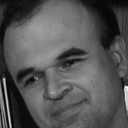

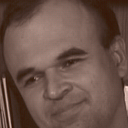

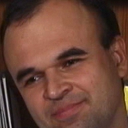

In [252]:
show(cNet,Tbatch_x,Tbatch_y,1,1)

Input to the network,coloring network output and original image	


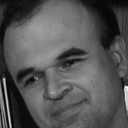

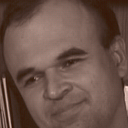

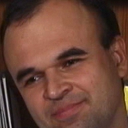

Input to the network,coloring network output and original image	


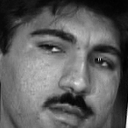

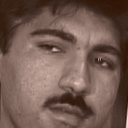

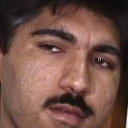

Input to the network,coloring network output and original image	


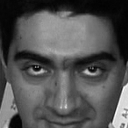

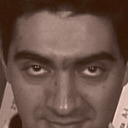

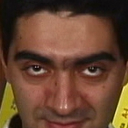

Input to the network,coloring network output and original image	


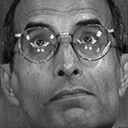

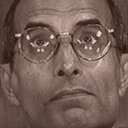

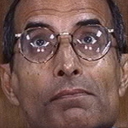

Input to the network,coloring network output and original image	


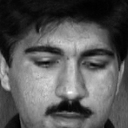

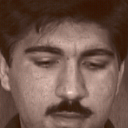

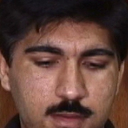

Input to the network,coloring network output and original image	


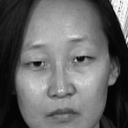

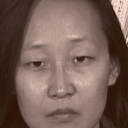

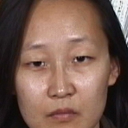

Input to the network,coloring network output and original image	


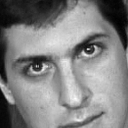

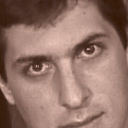

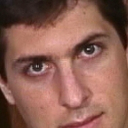

Input to the network,coloring network output and original image	


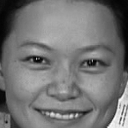

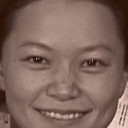

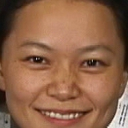

Input to the network,coloring network output and original image	


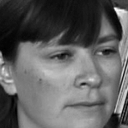

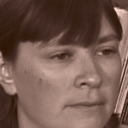

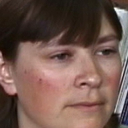

Input to the network,coloring network output and original image	


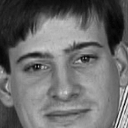

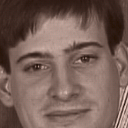

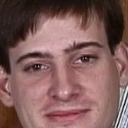

Input to the network,coloring network output and original image	


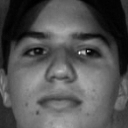

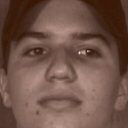

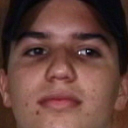

Input to the network,coloring network output and original image	


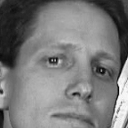

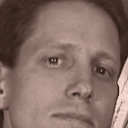

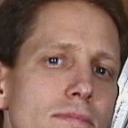

Input to the network,coloring network output and original image	


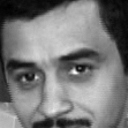

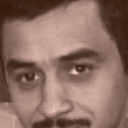

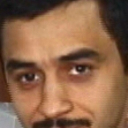

Input to the network,coloring network output and original image	


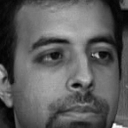

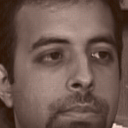

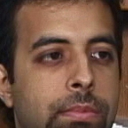

Input to the network,coloring network output and original image	


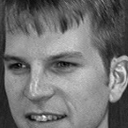

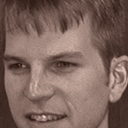

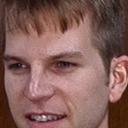

Input to the network,coloring network output and original image	


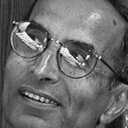

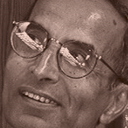

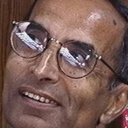

Input to the network,coloring network output and original image	


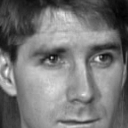

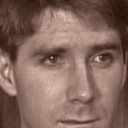

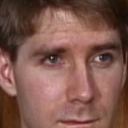

Input to the network,coloring network output and original image	


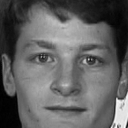

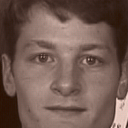

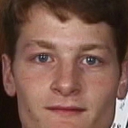

Input to the network,coloring network output and original image	


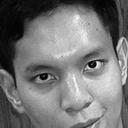

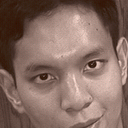

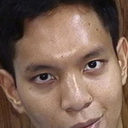

Input to the network,coloring network output and original image	


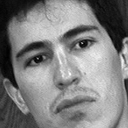

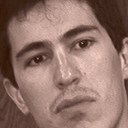

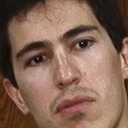

Input to the network,coloring network output and original image	


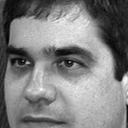

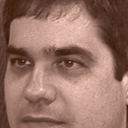

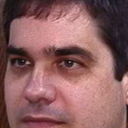

In [253]:

for i=1,7 do
    for j=1,3 do
        show(cNet,Tbatch_x,Tbatch_y,i,j)
    end
end

## *Fun*

In [262]:
lfs=require 'lfs'
lfs.chdir('/Users/prabhat/Desktop')
I = image.load('i.jpg')
I=image.scale(I,128,128)

In [270]:
mybatch=torch.Tensor(1,1,10,128,128)
for i=1,10 do
    mybatch[1][1][i]=ilab[1]/100
end

In [272]:
pic=cNet:forward(mybatch[1])
netPic=torch.Tensor(3,128,128)
netPic[1]=ilab[1]
netPic[2]=pic[1][1]*128
netPic[3]=pic[1][2]*128

original image, original lab space image and networks coloring	


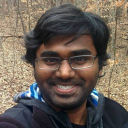

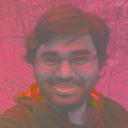

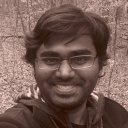

In [275]:
print('original image, original lab space image and networks coloring')
itorch.image(I)
itorch.image(ilab)
itorch.image(image.lab2rgb(netPic))

# WRITE-UP

*** Experiment 1: *** Increasing the number of feature maps in the network 
Increasing feature maps dint seem to have any effect on the training error. Leaving it at 3 feature maps in each layer seemed to do just fine. I tried with a variety of combinations as high as 60 and the training error seemed to be quite close to the net with 3 feature maps everywhere. Maybe the reason lies in the fact that the entire data set consists of faces, mostly front facing and the network is pretty deep so doesnt really need a lot feature maps. Best training error for the coloring net was around 19 for mean chrominance a and b. Interms of the coloring network the best test case error, MSE was achieved at 0.05 averagedMSE across all the values.

*** Experiment 2: *** ReLU vs Tanh Activations 
I tried using ReLU activations and Tanh activations across the entire network, and it showed that there wasn't much benefit to using tanh across the entire network. Though using only ReLU lead to a higher training error across all iterations. The best of all combinations was using ReLU everywhere except in the output where Tanh was used, this lead to faster convergence and better training error. Though i wonder if faster convergence means much since the data set was small. However, using ReLU in the final coloring network proved futile, all the chrominance predictions for each pixel would be pushed to -1 or 1, hence only Tanh() was used throughout the coloring network.   

*** Best architecture and MSE in terms of lab space channels a & b ***
The one displayed above. The train and test MSE can be seen above. 

*** Future Work:*** 

* BatchNormalization + Dropout, this combination is often citied as being way better than just one of them. 

* Bigger DataSet and Better Data Augmentation- maybe a bigger train data and better data augmentation would have made the network perform better.  


# References:
*** https://github.com/torch

*** https://github.com/Atcold/torch-Video-Tutorials

*** https://groups.google.com/forum/#!topic/torch7/nPvkE9uV550